# Using Parallel Computing in fmdtools

This notebook will discuss how to use parallel programming in fmdtools, including:
- how to set up a model for parallelism
- syntax for using parallelism in simulation functions
- considerations for optimizing computational performance in a model

In [1]:
import sys
paths = sys.path
if paths[1]!='../':
    sys.path=[sys.path[0]] + ['../'] + paths

from ex_pump import * 
from fmdtools.modeldef import SampleApproach
import fmdtools.faultsim.propagate as propagate
import fmdtools.resultdisp as rd

This notebook uses the pump example (see ex_pump.py) to illustrate the use of parallelism in fmdtools. This is fairly simple model, and thus it should be noted that there may be considerations with more complex models which may not be adequately covered here.

In [2]:
mdl = Pump()

In [3]:
endresults, resgraph, mdlhist = propagate.nominal(mdl)

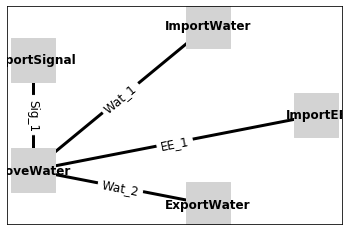

In [4]:
rd.graph.show(resgraph)

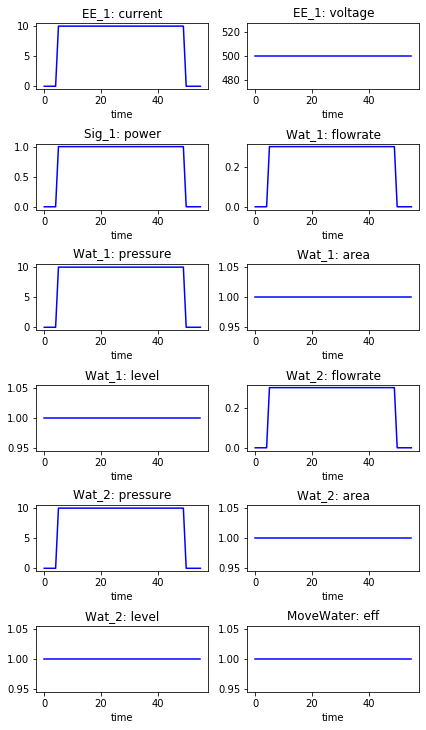

In [5]:
rd.plot.mdlhistvals(mdlhist)

## Model Checks

Before attempting to leverage parallelism in model execution, it can be helpful to check whether a model is compatible with python parallel computing libraries. In order for a model to be parallelized, it must be compatible with [pickling](https://docs.python.org/3/library/pickle.html#:~:text=%E2%80%9CPickling%E2%80%9D%20is%20the%20process%20whereby,back%20into%20an%20object%20hierarchy.)--python's method of data serialization. This is used in parallel programming methods to copy the model from the main process thread to the seperate processes of the pool.

fmdtools has two methods to check whether a model can be pickled, `check_pickleability` and `check_model_pickleability`. The main difference between these is that `check_pickleability` works for all objects (e.g. functions and flows), while `check_model_pickleability` gives more information for an overall model structure

In [6]:
from fmdtools.modeldef import check_pickleability, check_model_pickleability

In [7]:
unpickleable_attributes = check_pickleability(mdl)

The object is pickleable


In [8]:
check_model_pickleability(mdl)

The object is pickleable


As you can see, this model is pickleable. However, this may not be the case for all structures if they rely on unpickleable data structures. For example:

In [9]:
mdl.fxns['ImportEE'].bad_fxn_attribute = {1:2,3:4}.keys()
mdl.flows['EE_1'].bad_flow_attribute = {1:2,3:4}.keys()

In [10]:
check_model_pickleability(mdl)

The following attributes will not pickle: ['flows', 'fxns', 'graph']
FLOWS 
EE_1
The following attributes will not pickle: ['bad_flow_attribute']
Sig_1
The object is pickleable
Wat_1
The object is pickleable
Wat_2
The object is pickleable
FUNCTIONS 
ImportEE
The following attributes will not pickle: ['flows', 'EEout', 'bad_fxn_attribute']
ImportWater
The object is pickleable
ImportSignal
The object is pickleable
MoveWater
The following attributes will not pickle: ['flows', 'EEin']
ExportWater
The object is pickleable


In this case, because the `ImportEE` function and `EE_1` flow was given a an unpicklable attribute (a `dict_keys()` object) and thus the interfacing functions and overall model will not pickle. To fix this, one could easily convert these attributes into lists, sets, or dictionaries.

In [11]:
mdl = Pump()

## Using Parallelism in Simulation

Parallelism generally requires using some external parallel processing toolkit. The syntax used by fmdtools methods is compatible with:
- [multiprocessing](https://docs.python.org/3/library/multiprocessing.html), python's default parallel computing library
- [multiprocess](https://pypi.org/project/multiprocess/), a fork of multiprocessing developed by The UQ Foundation
- [pathos](https://github.com/uqfoundation/pathos), a broader parallel computing package developed by The UQ Foundation

In [6]:
import multiprocessing as mp
import multiprocess as ms
from pathos.pools import ParallelPool, ProcessPool, SerialPool, ThreadPool

Parallelism can speed up simulation time when there is a large number of independent simulations to run. The main interface for using parallelism is thus using the `run_singlefaults` (usually used in static models) and `run_approach` methods. They can be run in parallel by sending them a `pool` object from one of these modules as the optional `pool` argument.

In [13]:
pool = mp.Pool(4)
app = SampleApproach(mdl)
endclasses, mdlhists = propagate.approach(mdl,app, pool=pool)
rd.tabulate.simplefmea(endclasses)

,rate,cost,expected cost
"ImportWater no_wat, t=2",0.000017,11125.00,18541.666667
"ImportSignal no_sig, t=2",0.000002,20125.00,4312.500000
"MoveWater mech_break, t=2",0.000002,15125.00,3241.071429
"MoveWater short, t=2",0.000021,30125.00,64553.571429
"ExportWater block, t=2",0.000021,20100.25,43071.964286
"ImportEE no_v, t=27",0.000360,15175.00,546300.000000
"ImportEE inf_v, t=27",0.000090,20175.00,181575.000000
"ImportWater no_wat, t=27",0.000150,6175.00,92625.000000
"ImportSignal no_sig, t=27",0.000013,15175.00,19510.714286
"MoveWater mech_break, t=27",0.000231,10175.00,235478.571429


In [14]:
pool = mp.Pool(4)
endclasses, mdlhists = propagate.single_faults(mdl,app, pool=pool)
rd.tabulate.simplefmea(endclasses)

,rate,cost,expected cost
"ImportEE no_v, t=0",0.000448,20125.00,901600.0
"ImportEE inf_v, t=0",0.000112,25125.00,281400.0
"ImportWater no_wat, t=0",0.000560,11125.00,623000.0
"ImportSignal no_sig, t=0",0.000056,21125.00,118300.0
"MoveWater mech_break, t=0",0.000336,15125.00,508200.0
"MoveWater short, t=0",0.000560,35125.00,1967000.0
"ExportWater block, t=0",0.000560,20100.25,1125614.0
"ImportEE no_v, t=20",0.000448,16750.00,750400.0
"ImportEE inf_v, t=20",0.000112,21750.00,243600.0
"ImportWater no_wat, t=20",0.000560,22750.00,1274000.0


It can also be helpful to verify that the results of parallel simulation and normal serial execution are the same:

In [15]:
endclasses_par, mdlhists = propagate.single_faults(mdl, pool=pool)
tab_par = rd.tabulate.simplefmea(endclasses_par)
endclasses, mdlhists = propagate.single_faults(mdl)
tab = rd.tabulate.simplefmea(endclasses)
tab - tab_par

,rate,cost,expected cost
"ImportEE no_v, t=0",0.0,0.0,0.0
"ImportEE inf_v, t=0",0.0,0.0,0.0
"ImportWater no_wat, t=0",0.0,0.0,0.0
"ImportSignal no_sig, t=0",0.0,0.0,0.0
"MoveWater mech_break, t=0",0.0,0.0,0.0
"MoveWater short, t=0",0.0,0.0,0.0
"ExportWater block, t=0",0.0,0.0,0.0
"ImportEE no_v, t=20",0.0,0.0,0.0
"ImportEE inf_v, t=20",0.0,0.0,0.0
"ImportWater no_wat, t=20",0.0,0.0,0.0


In [16]:
endclasses_par, mdlhists = propagate.approach(mdl, app, pool=pool)
tab_par = rd.tabulate.simplefmea(endclasses_par)
endclasses, mdlhists = propagate.approach(mdl, app)
tab = rd.tabulate.simplefmea(endclasses)
tab - tab_par

,rate,cost,expected cost
"ImportWater no_wat, t=2",0.0,0.0,0.0
"ImportSignal no_sig, t=2",0.0,0.0,0.0
"MoveWater mech_break, t=2",0.0,0.0,0.0
"MoveWater short, t=2",0.0,0.0,0.0
"ExportWater block, t=2",0.0,0.0,0.0
"ImportEE no_v, t=27",0.0,0.0,0.0
"ImportEE inf_v, t=27",0.0,0.0,0.0
"ImportWater no_wat, t=27",0.0,0.0,0.0
"ImportSignal no_sig, t=27",0.0,0.0,0.0
"MoveWater mech_break, t=27",0.0,0.0,0.0


While fmdtools built-in methods are the easiest way to leverage parallelism, it can also be used with custom arguments/methods to meet the needs of simulation. However, (on Windows) these methods need to be defined in an external module with an "if __name__=='__main__':" statement, otherwise execution will hang from spawning new processes. This has to do with how multiprocessing works in windows.

Below the model is run over the blockage fault mode at time t=1 with a different model parameter (delayed failure behavior), as defined in the `parallelism_methods.py` module in this folder.

In [6]:
from parallelism_methods import delay_test

In [7]:
results = delay_test()

In [8]:
results

[{'flows': {'Wat_2': {'area': 0.01}},
  'faults': {'MoveWater': ['mech_break'], 'ExportWater': ['block']},
  'classification': {'rate': 0.00055,
   'cost': 20125.000000000007,
   'expected cost': 1106875.0000000005}},
 {'flows': {'Wat_2': {'area': 0.01}},
  'faults': {'MoveWater': ['mech_break'], 'ExportWater': ['block']},
  'classification': {'rate': 0.00055,
   'cost': 20100.250000000007,
   'expected cost': 1105513.7500000005}},
 {'flows': {'Wat_2': {'area': 0.01}},
  'faults': {'MoveWater': ['mech_break'], 'ExportWater': ['block']},
  'classification': {'rate': 0.00055,
   'cost': 20077.750000000007,
   'expected cost': 1104276.2500000005}},
 {'flows': {'Wat_2': {'area': 0.01}},
  'faults': {'MoveWater': ['mech_break'], 'ExportWater': ['block']},
  'classification': {'rate': 0.00055,
   'cost': 20055.250000000007,
   'expected cost': 1103038.7500000005}},
 {'flows': {'Wat_2': {'area': 0.01}},
  'faults': {'MoveWater': ['mech_break'], 'ExportWater': ['block']},
  'classification': {